In [1]:
import numpy as np
import gym

def simple_policy(state):
    action = 0 if state < 5 else 1
    return action

env = gym.make('CartPole-v0')
alpha = 0.1
gamma = 0.99

state_space = np.linspace(-0.2094, 0.2094, 10)
V = {}
for state in range(len(state_space)+1):
    V[state] = 0
    
for i in range(5000):
    state_null = env.reset()
    done = False
    while not done:
        state = int(np.digitize(state_null[2], state_space))
        action = simple_policy(state)
        state_prime, reward, done, info = env.step(action)
        digitized_state_prime = int(np.digitize(state_prime[2], state_space))
        V[state] = V[state] + alpha*(reward + gamma*V[digitized_state_prime] - V[state])
        state_null = state_prime
        
for state in V:
    print("state: {}\t->\tV[state]: {}".format(state,V[state]))

In [2]:
class QAgent():
    def __init__(self, lr, gamma, n_actions, state_space, \
                 epsilon, epsilon_end, epsilon_dec):
        #learning rate (a.k.a. alpha)
        self.lr, self.gamma, self.n_actions = lr, gamma, n_actions
        
        self.epsilon, self.epsilon_end, self.epsilon_dec = \
            epsilon, epsilon_end, epsilon_dec
        
        self.state_space = state_space
        self.action_space = [i for i in range(self.n_actions)]
        
        self.Q = {}
        
        self.init_Q()
        
    def init_Q(self):
        for state in self.state_space:
            for action in self.action_space:
                self.Q[(state, action)] = 0.0
                
    def max_action(self, state):
        actions = np.array([self.Q[state, a] for a in self.action_space])
        action = np.argmax(actions)
        
        return action

    def choose_action(self, state):
        if np.random.random() < self.epsilon:
            action = np.random.choice(self.action_space)
        else:
            action = self.max_action(state)
            
        return action
        
    def decrement_epsilon(self):
        self.epsilon = self.epsilon - self.epsilon_dec if self.epsilon > self.epsilon_end \
            else self.epsilon_end
        
    #update estimate Q
    def learn(self, state_null, action, reward, state_prime):
#         print("state_null: {}".format(state_null))
#         print("state_prime: {}".format(state_prime))
#         print("action: {}".format(action))
        
        a_max = self.max_action(state_prime)
        
        self.Q[(state_null, action)] = self.Q[(state_null, action)] + self.lr * \
            (reward + self.gamma * self.Q[(state_null, a_max)]) - \
            self.Q[(state_null, action)]

In [3]:
import matplotlib.pyplot as plt
import numpy as np

In [4]:
class CartPoleStateDigitizer():
    def __init__(self, bounds=(2.4,4,0.209,4), n_bins=10):
        bound_names = ["position","velocity","pole_angle_space","pole_velocity"]
        #set bounds for each state space
        self.state_subspaces = {b: np.linspace(-1*bounds[i], bounds[i], n_bins) for i,b in \
                                enumerate(bound_names)}
        self.states = self.get_state_space()
        
    def get_state_space(self):
        states = []
        for i in range(len(self.state_subspaces["position"])+1):
            for j in range(len(self.state_subspaces["velocity"])+1):
                for k in range(len(self.state_subspaces["pole_angle_space"])+1):
                    for l in range(len(self.state_subspaces["pole_velocity"])+1):
                        states.append((i,j,k,l))
        return states
    
    def digitize(self, observation):
        # x position, x velocity, angle, angle velocity
        bound_names = ["position","velocity","pole_angle_space","pole_velocity"]
        zipped_states = zip(bound_names,[o for o in observation])
#         print(zipped_states)
#         x, x_dot, theta, theta_dot = observation
        cart = {b: int(np.digitize(o, self.state_subspaces[b])) for b,o in zipped_states}
#         print(tuple(cart.values()))
    
        return tuple(cart.values())
    
def plot_learning_curve(scores, x):
    running_average = np.zeros(len(scores))
    for i in range(len(running_average)):
        running_average[i] = np.mean(scores[max(0,i-100):(i+1)])
    plt.plot(x, running_average)
    plt.title('Running Average of Previous 100 Scores')
    plt.show()

CPS = CartPoleStateDigitization()
print(type(CPS.state_subspaces))
print(CPS.state_subspaces)

Episode: 0	Score: 18.0	Epsilon: 1.0
Episode: 5000	Score: 18.0	Epsilon: 0.7999999999998
Episode: 10000	Score: 15.0	Epsilon: 0.5999999999996
Episode: 15000	Score: 40.0	Epsilon: 0.3999999999995388
Episode: 20000	Score: 11.0	Epsilon: 0.1999999999995816
Episode: 25000	Score: 45.0	Epsilon: 0.01
Episode: 30000	Score: 19.0	Epsilon: 0.01
Episode: 35000	Score: 32.0	Epsilon: 0.01
Episode: 40000	Score: 28.0	Epsilon: 0.01
Episode: 45000	Score: 34.0	Epsilon: 0.01


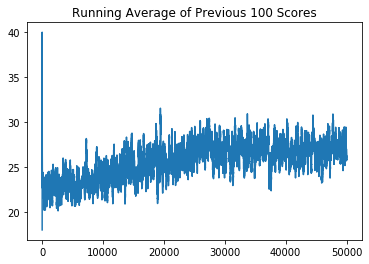

In [5]:
env = gym.make('CartPole-v0')
n_games = 50000
eps_dec = 2 / n_games
digitizer = CartPoleStateDigitizer()
agent = QAgent(lr=0.01, gamma=0.99, n_actions=2, \
               epsilon=1.0, epsilon_end=0.01, epsilon_dec=eps_dec, \
               state_space=digitizer.states)

scores = []
for i in range(n_games):
    observation_null = env.reset()
    done = False
    score = 0
    state_null = digitizer.digitize(observation_null)

    while not done:
        action = agent.choose_action(state_null)
        observation_prime, reward, done, info = env.step(action)
        state_prime = digitizer.digitize(observation_prime)
        agent.learn(state_null, action, reward, state_prime)
        state_null = state_prime
        score += reward
        
    if i % 5000 == 0:
        print("Episode: {}\tScore: {}\tEpsilon: {}".format(i,score,agent.epsilon))
        
    agent.decrement_epsilon()
    scores.append(score)
    
x = [i+1 for i in range(n_games)]
plot_learning_curve(scores, x)